In [43]:
%matplotlib inline
import requests
import simplejson as json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from heapq import *
import datetime
import warnings
import itertools
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

API_ENDPOINT = "http://localhost:7000/getDataForLinkID"

def getDataForNode(source, destination):
    data = {
        "source":source,
        "destination":destination,
        "duration" : "3",
        "time":"2018-05-09T17:15:00.000Z"
    }

    r = requests.post(url = API_ENDPOINT, data = data)

    data_recieved = json.loads(r.text)
    data_recieved = data_recieved["data"]
    return data_recieved

In [82]:
def dijkstra(edges, f, t):
    g = defaultdict(list)
    for l,r,c in edges:
        g[l].append((c,r))

    q, seen = [(0,f,())], set()
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: return (cost, path)

            for c, v2 in g.get(v1, ()):
                if v2 not in seen:
                    heappush(q, (cost+c, v2, path))

    return float(-inf)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = np.log1p(dataset[i]) - np.log1p(dataset[i - interval])
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def ArimaTest(y):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return results
def getForecast(source, destination):
    list_time=[]
    dataset = getDataForNode(source, destination)
    for item in dataset:
        myDate = ""
        initial = item["time"].split("T")
        myDate = initial[0] + " "
        time = initial[1].split(":")
        hours = time[0]
        minutes = time[1]
        myDate = myDate + str(hours) + ":" + str(minutes) + ":" + "00"
        item["time"] = myDate

    df_traffic = pd.DataFrame(dataset)
    #making time col to index
    df_traffic['index'] = df_traffic['time']
    df_traffic.set_index(['index'], inplace=True)
    df_traffic.index.name = None
    #deleting col time
    del df_traffic['time']
    del df_traffic['_id']
    #changing names
    df_traffic.columns = ['ridesCount','link_id','source']
    for date in df_traffic.index:
        list_time.append(datetime.strptime(date,'%Y-%m-%d %H:%M:%S'))
    selected_df=df_traffic
    df_traffic.index = list_time
    #Sorting it
    selected_df.sort_index(inplace=True)
    
#     selected_df.ridesCount.plot(figsize=(12,8), title= 'Daily Rider', fontsize=14)
#     plt.xlabel('Timestamp', weight='bold', size='large')
#     plt.ylabel('Count of traffic', weight='bold', size='large')

    #Seasonal Decompose using Moving Average
#     decomposition = seasonal_decompose(selected_df.ridesCount, model='additive',freq = 60)  
#     fig = plt.figure()  
#     fig = decomposition.plot()  
#     fig.set_size_inches(15, 8)
    
    #Auto Correlation Plot
    lnrides_Count=np.log1p(selected_df.ridesCount)
    lnrides_Count.plot(figsize=(12,8))
    acf_1 =  acf(lnrides_Count)
#     plt.plot(acf_1)
#     plt.savefig('ts_autocorrelation.png', bbox_inches='tight')
#     plt.show()
    
    #AutoCorrelation Test
    test_df = pd.DataFrame([acf_1]).T
    test_df.columns = ['Autocorrelation']
    test_df.index += 1
    test_df.plot(kind='bar')
    
    #Partial Auto Correlation Plot
    pacf_1 =  pacf(lnrides_Count)[1:20]
    plt.plot(pacf_1)
#     plt.savefig('ts_PartialAutocorrelation.png', bbox_inches='tight')
    plt.show()
    
    #Partial AutoCorrelation Test
    test_df = pd.DataFrame([pacf_1]).T
    test_df.columns = ['Partial Autocorrelation']
    test_df.index += 1
    test_df.plot(kind='bar')
    
    #Augmented Dickey Fuller Test
    result = tsa.adfuller(lnrides_Count, 1)
    
    #First Difference Autocorrelation
    lncount_diff=lnrides_Count-lnrides_Count.shift()
    diff=lncount_diff.dropna()
    acf_1_diff =  acf(diff)[1:20]
    
    #Test First Difference Autocorrelation
    test_df = pd.DataFrame([acf_1_diff]).T
    test_df.columns = ['First Difference Autocorrelation']
    test_df.index += 1
    test_df.plot(kind='bar')
    
    #First Difference Partial Correlation Difference
    pacf_1_diff =  pacf(diff)[1:20]
    plt.plot(pacf_1_diff)
#     plt.savefig('ts_1stDiff_partial_Correlation.png', bbox_inches='tight')
    plt.show()
    
    #ARIMA Model
    rides_CountMatrix = lnrides_Count.as_matrix()
    print("ARIMA Test")
    results = ArimaTest(rides_CountMatrix)
#     print("Actual ARIMA")
#     model = ARIMA(rides_CountMatrix, order=(6,1,1))
#     model_fit = model.fit(disp=0)
    print(results.summary())
    #Diagnostics Plot
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    
    #Predicting Values
    np.exp(results.predict(1, 287))
    selected_df['forecast'] = np.exp(results.predict(1, 287))
    selected_df[['ridesCount', 'forecast']].plot(figsize=(12, 8)) 
#     plt.savefig('ts_df_predict.png', bbox_inches='tight')
    
    #Dynamic forecasting
    npredict =selected_df.ridesCount['2018'].shape[0]
    fig, ax = plt.subplots(figsize=(12,6))
    npre = 12
    ax.set(title='Riders', xlabel='Date', ylabel='Riders')
    ax.plot(selected_df.index[-npredict-npre+1:], selected_df.ix[-npredict-npre+1:, 'ridesCount'], 'o', label='Observed')
    ax.plot(selected_df.index[-npredict-npre+1:], selected_df.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
    legend = ax.legend(loc='lower right')
    legend.get_frame().set_facecolor('w')
#     plt.savefig('ts_predict_compare.png', bbox_inches='tight')
    
    #this is moved up
    
    starttime = datetime.strptime("2018-05-09 17:00:00", "%Y-%m-%d %H:%M:%S")
    date_list=[]
    for j in range(0,1):
        starttime = starttime + relativedelta(minutes=15)
        date_list.append(starttime)

    future = pd.DataFrame(index=date_list, columns= selected_df.columns)
    df = pd.concat([selected_df, future])
    
    starttime1 = df.index.get_loc(datetime.strptime("2018-05-08 17:00:00", "%Y-%m-%d %H:%M:%S"))
    starttime2 = df.index.get_loc(datetime.strptime("2018-05-07 17:00:00", "%Y-%m-%d %H:%M:%S"))
#     starttime3 = df.index.get_loc(datetime.strptime("2018-05-07 17:00:00", "%Y-%m-%d %H:%M:%S"))
    
    print(starttime1)
    
    print("Moin")
    
    print(selected_df)
    
    ##moved up
    
    #Future Forecasting
    X = selected_df.ridesCount
    interval = 15
    differenced = difference(X, interval)
    
    # fit model
    model = ARIMA(differenced, order=(6,1,1))
    model_fit = model.fit(disp=0)
    
    # one-step out of sample forecast
    start_index = len(differenced)
    end_index = len(differenced)

    forecast = model_fit.forecast(steps=1)[0]

    # invert the differenced forecast to something usable
    history = [x for x in X]
    futurelist=[]
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, interval)
        print('Next 15 min: %f' % inverted)
        futurelist.append(inverted)
    startTime = df.index.get_loc(datetime.strptime(str(date_list[0]), '%Y-%m-%d %H:%M:%S'))
    endTime = df.index.get_loc(datetime.strptime(str(date_list[len(date_list)-1]), '%Y-%m-%d %H:%M:%S'))
    j=0
#     for i in range(0,startTime):
#         df['forecast'][i] = None
#     for i in range(startTime, endTime):
#         df['forecast'][i] = futurelist[j]
#         j=j+1
    #df['forecast'][len(selected_df)] = inverted
#     df[['ridesCount', 'forecast']].plot(stacked=False,figsize=(12, 8))
#     plt.savefig('ts_predict_future.png', bbox_inches='tight')
#     print(df)
#     starttime1 = df.index.get_loc(datetime.strptime("2018-05-08 17:00:00", "%Y-%m-%d %H:%M:%S"))
#     starttime2 = df.index.get_loc(datetime.strptime("2018-05-07 17:00:00", "%Y-%m-%d %H:%M:%S"))
#     starttime3 = df.index.get_loc(datetime.strptime("2018-05-06 17:00:00", "%Y-%m-%d %H:%M:%S"))
    
    # Metrics of future values with Truth Values
    y_forecasted = inverted
    
    y_truth1 = selected_df.iloc[starttime1]
    y_truth2 = selected_df.iloc[starttime2]
    
    print("truth")
    print(y_truth1)

#     y_truth1 = selected_df["2018-05-08 17:00:00"]
#     y_truth2 = selected_df["2018-05-07 17:00:00"]
#     y_truth3 = selected_df[starttime3]

    y_truth_Actual = (y_truth1["ridesCount"]+y_truth2["ridesCount"])/2
    # Compute the mean square error
    mse = ((y_forecasted - y_truth_Actual) ** 2).mean() -100
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    return inverted

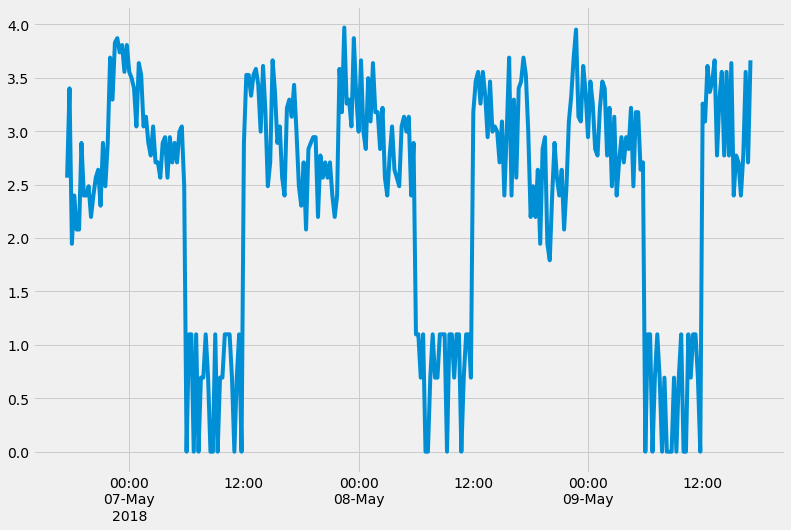

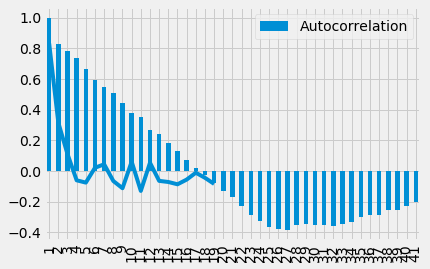

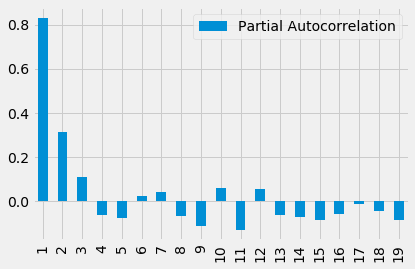

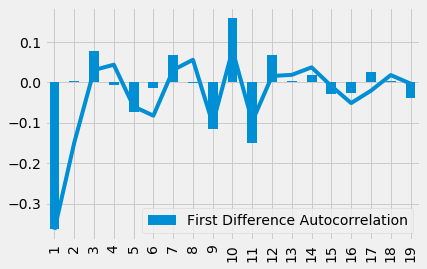

ARIMA Test
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1100.1127693628744
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:850.1782048376858
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:948.3327680968266
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:886.835667482825
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:927.4159100174707
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:852.1764918582722
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1086.0465555433643
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:897.6519749472188
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:806.8319815936378
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:696.6899542509343
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:788.9329851385851
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:726.9526318404041
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:777.36242760146
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:694.6853213686579
ARIMA(0, 1, 0)x(0, 0, 1

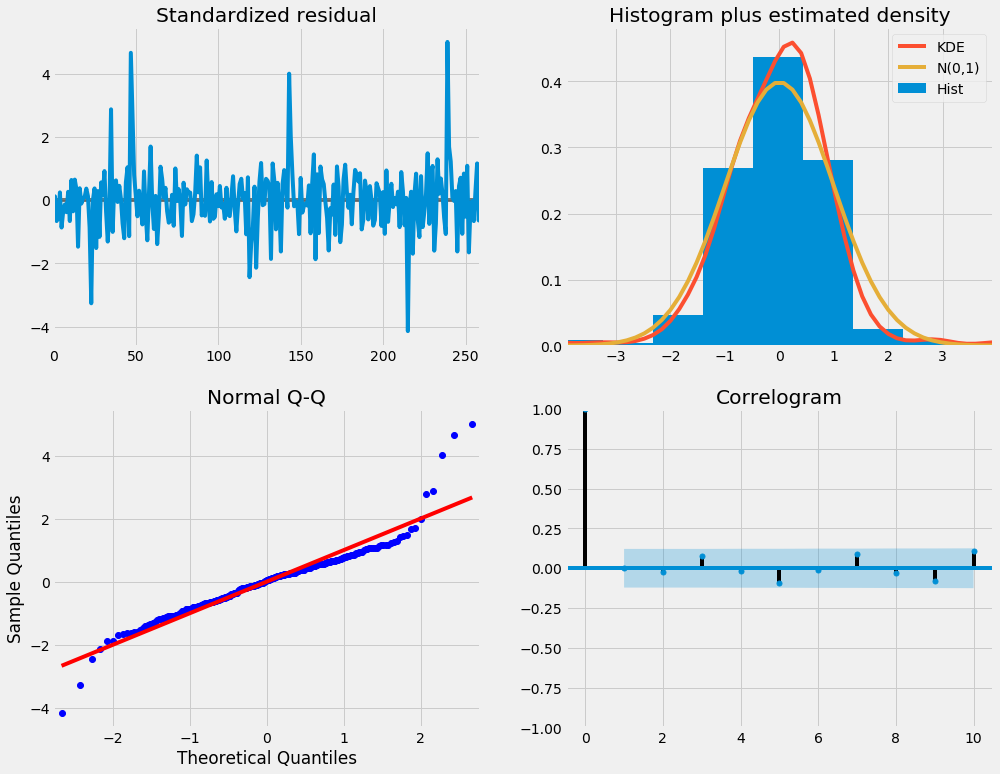

190
Moin
                     ridesCount link_id  source   forecast
2018-05-06 17:30:00          12  node_2  node_1  11.440524
2018-05-06 17:45:00          29  node_2  node_1  28.437845
2018-05-06 18:00:00           6  node_2  node_1   7.840071
2018-05-06 18:15:00          10  node_2  node_1  10.543470
2018-05-06 18:30:00           7  node_2  node_1   8.219611
2018-05-06 18:45:00           7  node_2  node_1   7.983916
2018-05-06 19:00:00          17  node_2  node_1  16.938365
2018-05-06 19:15:00          10  node_2  node_1  11.466408
2018-05-06 19:30:00          10  node_2  node_1  10.966107
2018-05-06 19:45:00          11  node_2  node_1  11.924525
2018-05-06 20:00:00           8  node_2  node_1   9.201001
2018-05-06 20:15:00          10  node_2  node_1  58.246247
2018-05-06 20:30:00          12  node_2  node_1  34.428643
2018-05-06 20:45:00          13  node_2  node_1   3.660795
2018-05-06 21:00:00           9  node_2  node_1  10.359386
2018-05-06 21:15:00          17  node_2  node_1

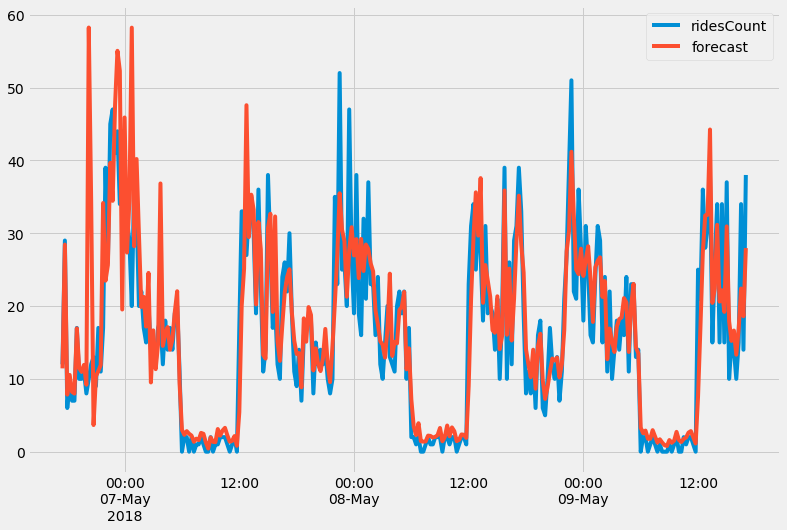

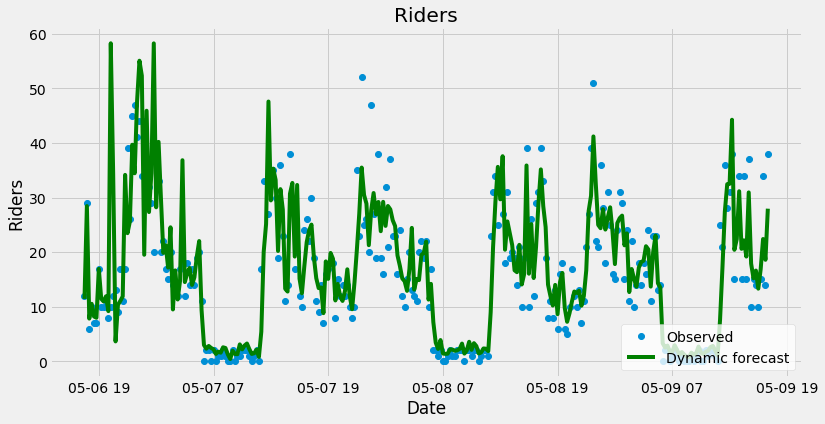

In [86]:
nodeList=['node_1','node_2','node_3','node_4','node_5','node_6','node_7','node_8']
pred1_2 = getForecast(nodeList[0],nodeList[1])
# pred2_3 = getForecast(nodeList[1],nodeList[2])
# pred3_4 = getForecast(nodeList[2],nodeList[3])
# pred4_5 = getForecast(nodeList[3],nodeList[4])
# pred6_5 = getForecast(nodeList[5],nodeList[4])
# pred7_6 = getForecast(nodeList[6],nodeList[5])
# pred8_7 = getForecast(nodeList[7],nodeList[6])
# pred1_8 = getForecast(nodeList[0],nodeList[7])
# pred3_7 = getForecast(nodeList[2],nodeList[6])

In [78]:
# pred3_7

In [87]:
#Dijkstra Algorithm
# if __name__ == "__main__":
edges = [
    ("node_1", "node_2", pred1_2),
    ("node_2", "node_3", pred2_3),
    ("node_3", "node_4", pred3_4),
    ("node_4", "node_5", pred4_5),
    ("node_1", "node_8", pred1_8),
    ("node_8", "node_7", pred8_7),
    ("node_7", "node_6", pred7_6),
    ("node_6", "node_5", pred6_5),
    ("node_3", "node_7", pred3_7),
]

print("node_1 -> node_5:")
value = dijkstra(edges, "node_1", "node_5")
print(value)

node_1 -> node_5:
(108.28321455986006, ('node_5', ('node_6', ('node_7', ('node_8', ('node_1', ()))))))


In [ ]:
def ARIMA()
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue